In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

plt.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['axes.linewidth'] = 2

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', family='serif', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)                    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)                    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)                    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)                    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title

# Get Raw Data

In [5]:
def ReadData(filename, startN, endN, maxParticles):
    NF = 20 #Number of data fields
    import numpy as np

    dt = np.dtype(np.float32)
    f = open(filename, "rb")

    p_data = np.zeros([NF,maxParticles,endN-startN])
    f.seek(0)
    P,T=np.fromfile(f, dtype=dt, count=1), np.fromfile(f, dtype=dt, count=1)
    f.seek(0)
    for i in range(endN-startN):
        numParticles = np.fromfile(f, dtype=dt, count=1)
        time = np.fromfile(f, dtype=dt, count=1)
        temp = np.fromfile(f, dtype=dt, count=NF*int(numParticles)).reshape((int(numParticles), NF)).transpose()
        p_data[:,0:temp.shape[1],i] = temp
        del temp
    return p_data, T

# Get Whole DataFrame

In [6]:
def dfWholeClean(data, filename, frame):
    import pandas as pd
    from numpy import cos, sin
    import math as m 
    from pyquaternion import Quaternion
    
    # Data --> DataFrame #
    df = pd.DataFrame(data={
        'x': data[2,:,frame],
        'y': data[3,:,frame],
        'z': data[4,:,frame],
        'v': data[5,:,frame],
        'w': data[6,:,frame],
        'u': data[7,:,frame],
        'a': data[11,:,frame],
        'b': data[12,:,frame],
        'c': data[13,:,frame],
        'q0': data[16,:,frame],  
        'q1': data[17,:,frame], 
        'q2': data[18,:,frame], 
        'q3': data[19,:,frame]}) 

    # Rotations and Calculations #
    x,y,z,a,b,c,thetay_arr, thetaz_arr, M_arr,uprime_arr = [],[],[],[],[],[],[],[],[],[]
    Raxis = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]]).T
    for i in range(len(df.x)):
        xyznew=Raxis.dot([df.x.iloc[i], df.y.iloc[i], df.z.iloc[i]])
        x.append(xyznew[0]), y.append(xyznew[1]), z.append(xyznew[2])
        a.append(df.a.iloc[i]), b.append(df.b.iloc[i]), c.append(df.c.iloc[i])
        quat=Quaternion([df.q0.iloc[i],df.q1.iloc[i],df.q2.iloc[i],df.q3.iloc[i]])
        M_old=np.array(quat.rotation_matrix)
        R = np.array(Raxis.dot(M_old)).T
        M_arr.append(R)    
        ogaxis=np.array([0,0,1]).T
        Vaxis=R.T.dot(ogaxis)
        thetay = np.rad2deg(np.arctan(Vaxis[2]/Vaxis[0]))
        thetaz = np.rad2deg(np.arctan(Vaxis[1]/Vaxis[0]))
        thetay_arr.append(thetay), thetaz_arr.append(thetaz)
        
        vwunew = Raxis.dot([df.v.iloc[i], df.w.iloc[i], df.u.iloc[i]])

        theta = np.deg2rad(-25)
        uprime = vwunew[0]*cos(theta)+vwunew[2]*sin(theta)
        uprime_arr.append(uprime)

    # New Dataframe #
    df1 = pd.DataFrame(data={#Get new rotated dataframe
        'x': x,
        'y': y,
        'z': z,
        'a': a,
        'b': b,
        'c': c,
        'M': M_arr,
        'thetay': thetay_arr,
        'thetaz': thetaz_arr,
        'uprime': uprime_arr})
    df1.index.name = filename

    return df1


# No Feed DataFrame

In [7]:
def dfClean(df):
    import pandas as pd
    import numpy as np
    import math as m 
    
    # Clean up DataFrame #
    df = df[df.a != 0] # Empty Spaces
    df = df[df.x > 0.08] # Feed Zone (used in Paper DOI 10.1002/aic.16035)
    
    # Calculate Z' and X' #
    zprime_arr, xprime_arr = [],[]
    for i in range(len(df.x)):
        p2x, p2z= df.loc[df['z'].idxmin()]['x'], 0      # x position associated with lowest z position, 0
        m_z = np.tan(np.deg2rad(-25))                   # slope
        b = -m_z*p2x                                    # p2z = m_z * p2x + b
        p1x, p1z= 0, b                                  # 0, y-intercept
        zprime = (abs((p2x-p1x)*(p1z-df.z.iloc[i])-(p1x-df.x.iloc[i])*(p2z-p1z)))/(m.sqrt((p2x-p1x)**2+(p2z-p1z)**2))
        zprime_arr.append(zprime)

        p2x_x, p2z_x= 0, b                              # 0, y-intercept
        m_x = -1/np.tan(np.deg2rad(-25))                # perpendicular slope
        p1x_x, p1z_x= .15, m_x*.15 + b                  # arbitrary x value of 0.15, p1z_x = m_x*0.15 + b
        xprime = (abs((p2x_x-p1x_x)*(p1z_x-df.z.iloc[i])-(p1x_x-df.x.iloc[i])*(p2z_x-p1z_x)))/(m.sqrt((p2x_x-p1x_x)**2+(p2z_x-p1z_x)**2))
        xprime_arr.append(xprime)
        
    df['zprime']=zprime_arr
    df['xprime']=xprime_arr
    
    # Clean up Excess Floating Particles #
    df = df[df.zprime < df.zprime.mean()*3]

    return df

# Save and Store Data

In [ ]:
for filename in os.listdir('RawData'):
    data0, T0 = ReadData('Data/'+filename, 0, 1, 90000)
    data, T = ReadData('Data/'+filename, int(T0)-100, int(T0), 90000)
    df_whole = dfWholeClean(data, filename, 0)
    df_whole.to_pickle('DataSets/'+filename+'/WholeDF')
    df_clean = dfClean(df_whole)
    df_clean.to_pickle('DataSets/CleanDF_all/'+filename+'_CleanDF')
    df_clean.to_pickle('DataSets/'+filename+'/CleanDF')

# Check Z' and X'

In [26]:
def check(filename):
    fig, ax = plt.subplots()
    df_whole = pd.read_pickle('DataSets/'+filename+'/WholeDF')
    sns.scatterplot(data=df_whole, x='x', y='z', color='lavender', s=2)

    # Clean up DataFrame #
    df = df_whole[df_whole.a != 0] # Empty Spaces
    df = df_whole[df_whole.x > 0.08] # Feed Zone (used in Paper DOI 10.1002/aic.16035)

    # Used in function CleanDF #
    p2x, p2z= df.loc[df['z'].idxmin()]['x'], 0      # x position associated with lowest z position, 0
    m_z = np.tan(np.deg2rad(-25))                   # slope
    b = -m_z*p2x                                    # p2z = m_z * p2x + b
    p1x, p1z= 0, b                                  # 0, y-intercept

    p2x_x, p2z_x= 0, b                              # 0, y-intercept
    m_x = -1/np.tan(np.deg2rad(-25))                # perpendicular slope
    p1x_x, p1z_x= .15, m_x*.15 + b                  # arbitrary x value of 0.15, p1z_x = m_x*0.15 + b

    # Plot X' and Z' Lines #
    plt.plot([p2x, p1x], [p2z, p1z], color='red', linewidth=2)
    plt.plot([p2x_x, p1x_x], [p2z_x, p1z_x], color='red', linewidth=2)

    # Calculate and Assert Slopes are Perpendicular #
    def slope(x1, y1, x2, y2):
        return (y2-y1)/(x2-x1)
    slope_z = slope(p1x, p1z, p2x, p2z)
    slope_x_theoretical = -1/slope_z
    slope_x = slope(p1x_x, p1z_x, p2x_x, p2z_x)

    assert math.isclose(slope_x_theoretical, slope_x, rel_tol=0.002), 'Slopes are not the same'

    # Check Clean Df #
    df_clean = pd.read_pickle('DataSets/'+filename+'/CleanDF')

    bin_num=10
    dfa = df_clean.sort_values(by=['xprime'])
    dfa['bin'] = pd.cut(dfa.xprime,bin_num, include_lowest = True)
    group = dfa.groupby('bin')
    dfsa = [group.get_group(x) for x in group.groups]

    for i in range(bin_num):
        sns.scatterplot(data=dfsa[i], x='x', y='z', s=2)
    return plt.show()

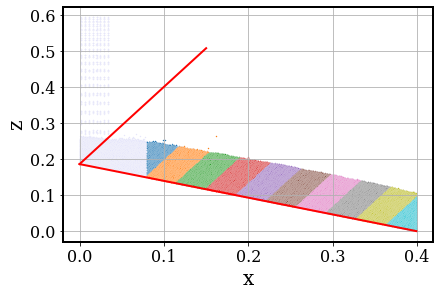

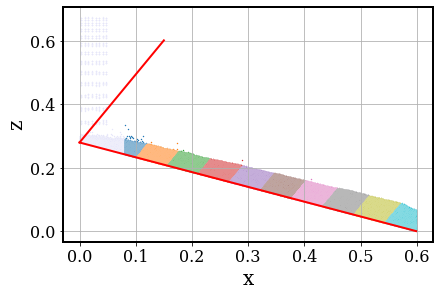

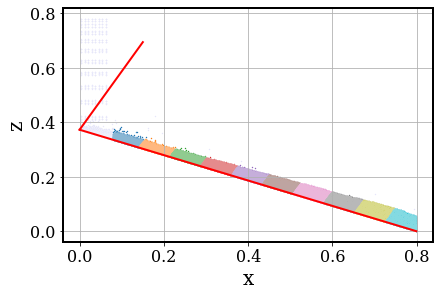

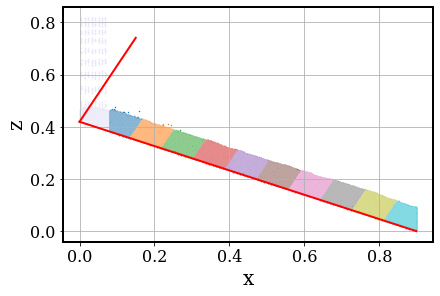

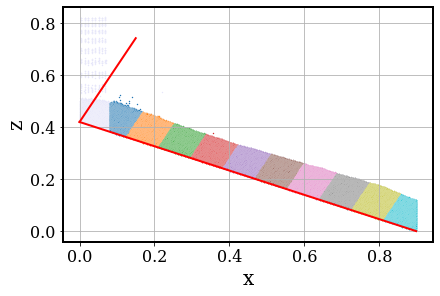

In [27]:
for filename in os.listdir('RawData'):
    check(filename)